In [4]:
import pandas as pd
from pandas import Series
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
RINK_LENGTH = 61.0
RINK_WIDTH = 27.0

# started with 12x8
N=14
M=10

In [6]:
def get_cell_indexes(l: int = N, w: int = M):
    """
    Returns a function that maps (x, y) coordinate Series to (xi, yj) grid cell indices.
    
    Parameters:
    - l: Number of grid columns (along rink length)
    - w: Number of grid rows (along rink width)
    
    Returns:
    - Function that accepts (x: Series, y: Series) and returns (xi, yj)
    """
    def indexer(x, y):
        x = x + (RINK_LENGTH / 2)  # Adjust x to range [0, 61]
        y = y + (RINK_WIDTH / 2)   # Adjust y to range [0, 27]
        x = pd.Series([x])
        y = pd.Series([y])
        xi = (x / RINK_LENGTH * l).astype("int64").clip(0, l - 1)
        yj = (y / RINK_WIDTH * w).astype("int64").clip(0, w - 1)
        return (xi.iloc[0], yj.iloc[0])

    return indexer

In [ ]:
# df = pd.read_pickle('../testing/X_clean.pkl')
df = pd.read_pickle('data/dirty_df.pkl')

In [8]:
index_fn = get_cell_indexes()

In [9]:
df['start_zone'] = df.apply(lambda row: index_fn(row['start_x_ai'], row['start_z_ai']), axis=1)
df['end_zone']   = df.apply(lambda row: index_fn(row['end_x_ai'], row['end_z_ai']), axis=1)

In [10]:
def count_zone_matrix(df, l=N, w=M):
    """
    Count the number of actions occurring in each cell of the grid using a specified zone column.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the action data.
    l : int, optional
        The number of grid cells along the x-axis (default is 12).
    w : int, optional
        The number of grid cells along the y-axis (default is 8).

    Returns
    -------
    np.ndarray
        A matrix, denoting the amount of actions occurring in each cell.
    """
    # Create an empty matrix with shape (w, l)
    count_matrix = np.zeros((w, l), dtype=int)
    
    for zone in df['start_zone']:
        if isinstance(zone, tuple) and len(zone) == 2:
            x, y = zone
            # Check if (x, y) is within bounds
            if 0 <= y < w and 0 <= x < l:
                count_matrix[y, x] += 1
    
    return count_matrix

In [11]:
start_zone_counts = count_zone_matrix(df, N, M)

In [12]:
print(start_zone_counts)

[[  50  957  984  873  755  581  498  422  589 1513 1409 1647 1263   32]
 [1056  917  616  704  727  602  465  293  629 1588 1081 1195  951  700]
 [1171  522  729  549  470  428  361  251  570 1205  882 1146  621  743]
 [1115  543  483  407  409  413  361  327  533 1234  779  778  775  680]
 [2206  696  402  383  421  405  467  279  455 1207  682  527 1048  585]
 [1968  672  408  470  418  445  467  285  474 1196  630  556 1063  502]
 [1114  478  475  487  439  433  386  283  503 1147  844  827  738  640]
 [1221  554  651  513  504  453  368  244  634 1162  979 1326  637  683]
 [1009  892  645  765  661  587  476  274  757 1480  937 1093  859  724]
 [  40  901  926  902  706  522  496  370  695 1440 1349 1563 1191   37]]


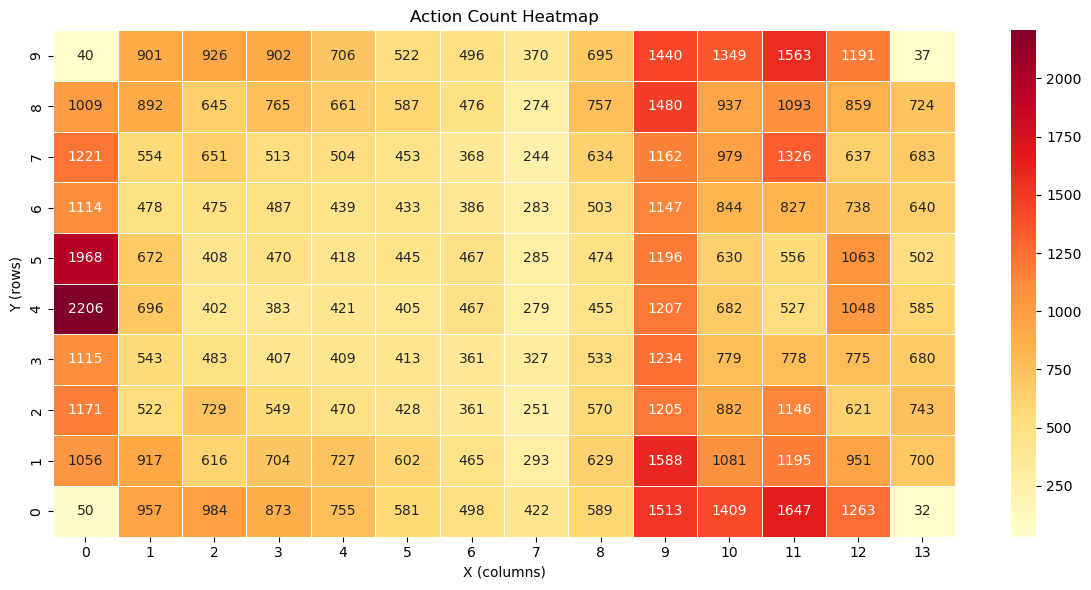

In [13]:
def plot_heatmap(matrix, title="Action Count Heatmap"):
    plt.figure(figsize=(12, 6))
    ax = sns.heatmap(matrix, annot=True, fmt="d", cmap="YlOrRd", linewidths=.5, square=False, cbar=True)
    ax.invert_yaxis()  # Zodat de 0e rij bovenaan staat, net als op een veld
    plt.title(title)
    plt.xlabel("X (columns)")
    plt.ylabel("Y (rows)")
    plt.tight_layout()
    plt.show()
    
plot_heatmap(start_zone_counts)

In [14]:
def _safe_divide(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    return np.divide(a, b, out=np.zeros_like(a, dtype="float64"), where=b != 0)

In [15]:
def scoring_prob(actions: pd.DataFrame, l: int = N, w: int = M) -> np.ndarray:
    """
    Compute the probability of scoring when taking a shot from each cell.

    Parameters
    ----------
    actions : pd.DataFrame
        DataFrame containing shot actions with 'start_zone' and 'actionresult_success'.
    l : int
        Number of grid cells in the x-direction.
    w : int
        Number of grid cells in the y-direction.

    Returns
    -------
    np.ndarray
        A matrix with scoring probabilities for each zone.
    """
    # Filter for shots
    shot_actions = actions[actions['actiontype_eventshot'] == 1]
    
    # Filter for successful shots (goals)
    goal_actions = shot_actions[shot_actions['actionresult_success'] == 1]
    
    # Count shots and goals per grid cell
    shot_matrix = count_zone_matrix(shot_actions, l, w)
    goal_matrix = count_zone_matrix(goal_actions, l, w)
    
    # Return the scoring probability matrix
    return _safe_divide(goal_matrix, shot_matrix)

In [16]:
scoring_probab = scoring_prob(df)

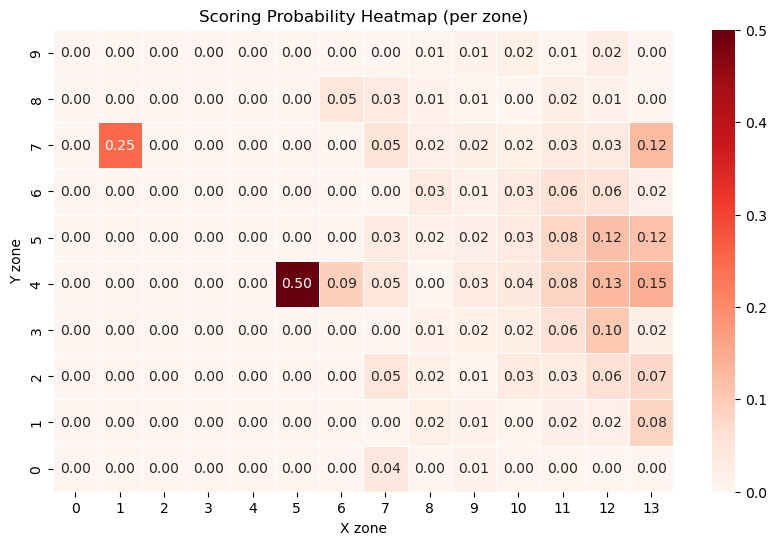

In [17]:
def plot_heatmap(prob_matrix, label):
    """
    Plot a heatmap of scoring probabilities.

    Parameters
    ----------
    prob_matrix : np.ndarray
        A 2D array where each cell represents scoring probability.
    """
    plt.figure(figsize=(10, 6))
    sns.heatmap(prob_matrix, annot=True, fmt=".2f", cmap="Reds", linewidths=0.5,
                xticklabels=range(prob_matrix.shape[1]), yticklabels=range(prob_matrix.shape[0]))
    plt.title(f"{label} Heatmap (per zone)")
    plt.xlabel("X zone")
    plt.ylabel("Y zone")
    plt.gca().invert_yaxis()  # Optional: match top-down field view
    plt.show()
    
plot_heatmap(scoring_probab, 'Scoring Probability')

In [18]:
def action_prob(actions: pd.DataFrame, l: int = N, w: int = M) -> tuple[np.ndarray, np.ndarray]:
    """
    Compute the probability of shooting or moving from each cell in the grid.

    Parameters
    ----------
    actions : pd.DataFrame
        DataFrame with action data including 'start_zone' and 'actiontype_eventshot'.
    l : int
        Number of grid cells along the x-axis.
    w : int
        Number of grid cells along the y-axis.

    Returns
    -------
    Tuple of np.ndarray
        shot_matrix: probability of shooting from each cell.
        move_matrix: probability of moving from each cell.
    """
    # Split shots and moves
    shot_actions = actions[actions['actiontype_eventshot'] == 1]
    move_actions = actions[actions['actiontype_eventshot'] == 0]

    # Count per zone
    shot_matrix = count_zone_matrix(shot_actions, l, w)
    move_matrix = count_zone_matrix(move_actions, l, w)
    total_matrix = shot_matrix + move_matrix

    # Probability = action count / total count
    shot_prob = _safe_divide(shot_matrix, total_matrix)
    move_prob = _safe_divide(move_matrix, total_matrix)

    return shot_prob, move_prob

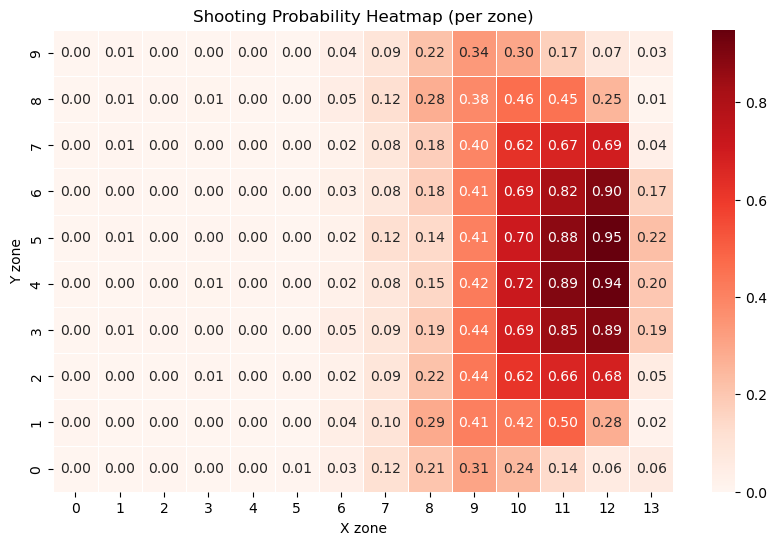

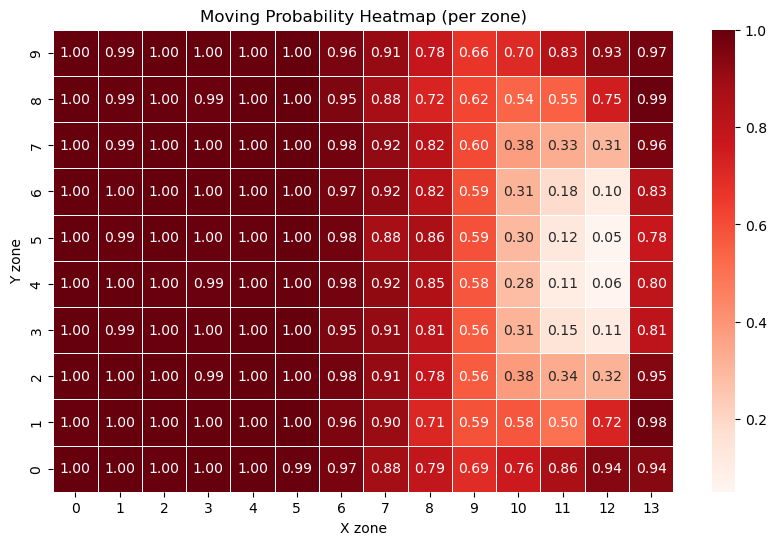

In [19]:
shot_prob, move_prob = action_prob(df)
plot_heatmap(shot_prob, 'Shooting Probability')
plot_heatmap(move_prob, 'Moving Probability')

In [20]:
def flatten_index(x: int, y: int, l: int) -> int:
    """Flatten 2D (x, y) index to 1D index for a grid of width l."""
    return y * l + x

def move_transition_matrix(actions: pd.DataFrame, l: int = N, w: int = M) -> np.ndarray:
    """
    Compute the move transition matrix for successful moves between zones.

    Parameters
    ----------
    actions : pd.DataFrame
        DataFrame with action data including 'start_zone', 'end_zone', and 'actionresult_success'.
    l : int
        Number of grid cells in the x-direction.
    w : int
        Number of grid cells in the y-direction.

    Returns
    -------
    np.ndarray
        A (l*w x l*w) transition probability matrix.
    """
    # Select only move actions
    move_actions = actions[actions['actiontype_eventshot'] == 0].copy()

    # Extract flat indices for start and end zones
    move_actions["start_cell"] = move_actions["start_zone"].apply(lambda z: flatten_index(z[0], z[1], l) if isinstance(z, tuple) else -1)
    move_actions["end_cell"] = move_actions["end_zone"].apply(lambda z: flatten_index(z[0], z[1], l) if isinstance(z, tuple) else -1)

    # Filter out invalid cells
    valid_moves = move_actions[(move_actions["start_cell"] >= 0) & (move_actions["end_cell"] >= 0)]

    # Count how often each start cell appears
    start_counts = np.zeros(w * l)
    start_cell_counts = valid_moves["start_cell"].value_counts()
    start_counts[start_cell_counts.index] = start_cell_counts

    # Initialize transition matrix
    transition_matrix = np.zeros((w * l, w * l))

    # Fill in transition probabilities for successful moves
    for start_cell in range(w * l):
        subset = valid_moves[
            (valid_moves["start_cell"] == start_cell) & (valid_moves["actionresult_success"] == 1)
        ]
        end_counts = subset["end_cell"].value_counts()
        if start_counts[start_cell] > 0:
            transition_matrix[start_cell, end_counts.index] = end_counts / start_counts[start_cell]

    return transition_matrix

In [21]:
trans_matrix = move_transition_matrix(df)

In [22]:
def plot_transition_from_zone(transition_matrix: np.ndarray, start_x: int, start_y: int, l: int = N, w: int = M):
    """
    Plot heatmap of transition probabilities from a specific (x, y) grid cell.

    Parameters
    ----------
    transition_matrix : np.ndarray
        The (l*w x l*w) move transition matrix.
    start_x : int
        X index of the starting cell.
    start_y : int
        Y index of the starting cell.
    l : int
        Grid width.
    w : int
        Grid height.
    """

    start_index = start_y * l + start_x
    transition_row = transition_matrix[start_index]  # All destinations from (start_x, start_y)

    # Reshape into 2D grid
    dest_matrix = transition_row.reshape((w, l))

    plt.figure(figsize=(10, 6))
    sns.heatmap(dest_matrix, annot=True, fmt=".2f", cmap="Blues", linewidths=0.5,
                xticklabels=range(l), yticklabels=range(w))
    plt.title(f"Move Transition Probabilities from Cell ({start_x}, {start_y})")
    plt.xlabel("Destination X")
    plt.ylabel("Destination Y")
    plt.gca().invert_yaxis()
    plt.show()

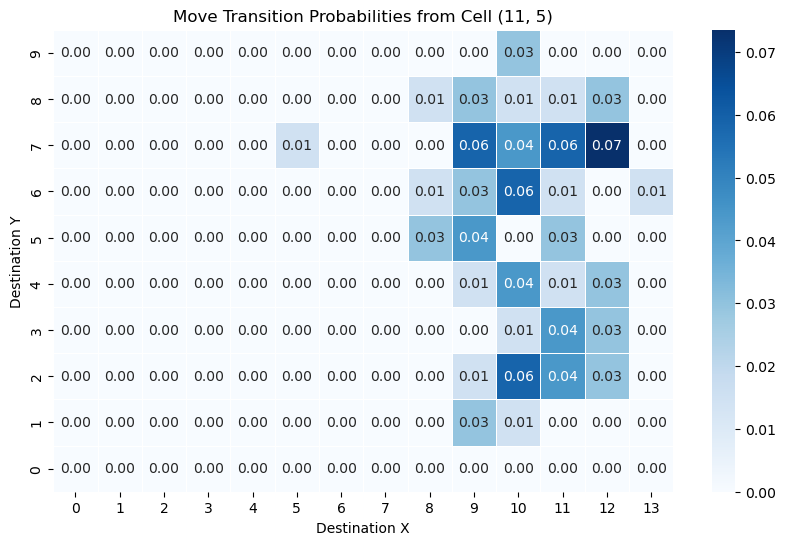

In [48]:
plot_transition_from_zone(trans_matrix, start_x=11, start_y=5)

In [24]:
class ExpectedThreat:
    def __init__(self, l=N, w=M, eps=1e-4, max_iter=100):
        self.l = l
        self.w = w
        self.eps = eps
        self.max_iter = max_iter

        self.xT = np.zeros((w, l), dtype=np.float64)  # Will hold the result
        self.scoring_prob_matrix = None
        self.shot_prob_matrix = None
        self.move_prob_matrix = None
        self.transition_matrix = None
        self.heatmaps = []  # Optional: store intermediate xT values

    def fit(self, df: pd.DataFrame):
        """Fit xT model on action data."""
        # Step 1: Estimate p(scoring | shot from cell)
        self.scoring_prob_matrix = scoring_prob(df, self.l, self.w)

        # Step 2: Estimate p(shot | cell) and p(move | cell)
        self.shot_prob_matrix, self.move_prob_matrix = action_prob(df, self.l, self.w)

        # Step 3: Estimate transition matrix for movement
        self.transition_matrix = move_transition_matrix(df, self.l, self.w)

        # Step 4: Solve the xT equation
        self.xT = self._solve(
            self.scoring_prob_matrix,
            self.shot_prob_matrix,
            self.move_prob_matrix,
            self.transition_matrix,
        )

        return self  # For chaining

    def _solve(self, p_scoring, p_shot, p_move, transition_matrix):
        """Dynamic programming to compute xT."""
        xT = np.zeros((self.w, self.l), dtype=np.float64)
        gs = p_scoring * p_shot

        for it in range(self.max_iter):
            total_payoff = np.zeros((self.w, self.l), dtype=np.float64)

            for y in range(self.w):
                for x in range(self.l):
                    idx = y * self.l + x
                    values = transition_matrix[idx].reshape((self.w, self.l)) * xT
                    total_payoff[y, x] = values.sum()

            new_xT = gs + (p_move * total_payoff)

            if np.all(np.abs(new_xT - xT) < self.eps):
                print(f"Converged after {it+1} iterations.")
                break

            xT = new_xT
            self.heatmaps.append(xT.copy())  # optional for visualization

        return xT

In [25]:
xt_model = ExpectedThreat(l=N, w=M)
xt_model.fit(df)  # your actions DataFrame

# Access the resulting xT values
xT = xt_model.xT

Converged after 34 iterations.


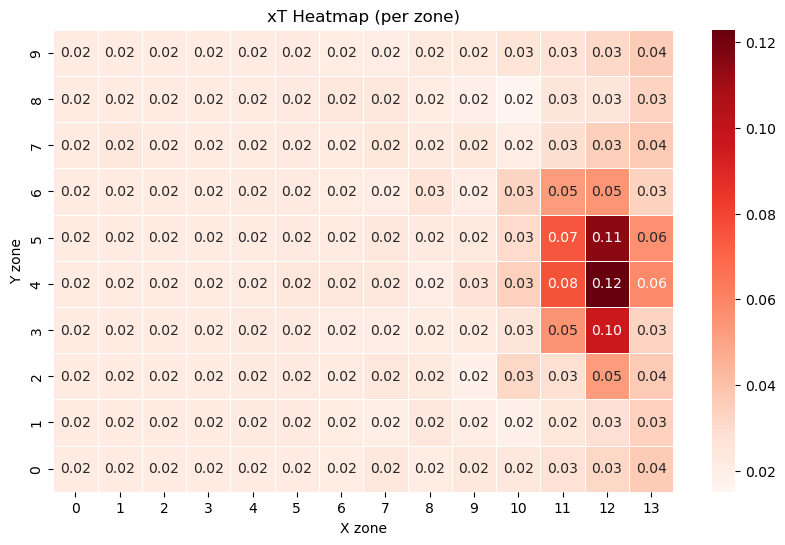

In [26]:
# Visualize
plot_heatmap(xT, 'xT')

In [40]:
game_id = 27
filtered_df = df[df['game_id'] == game_id]
filtered_df = filtered_df[filtered_df['actiontype_eventshot'] == 1]
successful_actions_id = filtered_df[filtered_df['actionresult_success'] == 1]

In [41]:
successful_actions_id.head(5)

,game_id,period,actiontype,actiontype_eventpass,actiontype_eventshot,actiontype_eventturnover,actionresult_success,actionresult_miss,time,team,...,strength_difference,defensive_density,speed,time_delta_i,dx_a0i,dy_a0i,mov_a0i,start_zone,end_zone,delta_xT
16048,27,1,EventShot,0,1,0,1,0,56,0,...,0,0.1455,8.183508,4.0,18.5815,-0.3353,18.584525,"(10, 3)","(13, 5)",0.030937
16117,27,1,EventShot,0,1,0,1,0,425,1,...,0,0.6135,5.847951,3.0,-28.1885,0.8511,28.201346,"(12, 5)","(13, 5)",-0.058750
16324,27,2,EventShot,0,1,0,1,0,1662,0,...,0,0.3696,5.309281,2.0,-39.3174,-4.1094,39.531571,"(11, 1)","(13, 5)",0.031537
16366,27,2,EventShot,0,1,0,1,0,1852,0,...,0,1.0684,2.541704,7.0,-48.2916,-4.3154,48.484031,"(10, 6)","(13, 5)",0.023547
16493,27,3,EventShot,0,1,0,1,0,2528,0,...,1,0.0000,1.551230,7.0,39.7410,8.7027,40.682724,"(12, 7)","(13, 5)",0.021528


In [46]:
index = 16117

In [47]:
total_xT_gain = 0

for i in range((index-2), (index+1)):
    row = df.loc[i]
    print("start zone: ", row['start_zone'])
    print("end zone: ", row['end_zone'])
    start = row['start_zone']  # should be a tuple like (x, y)
    end = row['end_zone']

    if isinstance(start, tuple) and isinstance(end, tuple):
        xT_start = xT[start[1], start[0]]  # y, x
        xT_end = xT[end[1], end[0]]        # y, x
        delta = xT_end - xT_start
        total_xT_gain += delta
        print(f"Action {i}: ΔxT = {delta:.4f}")
    else:
        print(f"Action {i} skipped (missing zone info)")

print(f"\nTotal xT gained across sequence: {total_xT_gain:.4f}")
    

start zone:  (np.int64(10), np.int64(8))
end zone:  (np.int64(9), np.int64(3))
Action 16115: ΔxT = 0.0065
start zone:  (np.int64(9), np.int64(1))
end zone:  (np.int64(11), np.int64(7))
Action 16116: ΔxT = 0.0086
start zone:  (np.int64(12), np.int64(5))
end zone:  (np.int64(13), np.int64(5))
Action 16117: ΔxT = -0.0588

Total xT gained across sequence: -0.0437


In [33]:
# Zorg dat er een nieuwe kolom delta_xT in df komt
delta_xT_values = []

for i, row in df.iterrows():
    start = row['start_zone']
    end = row['end_zone']
    
    if isinstance(start, tuple) and isinstance(end, tuple):
        xT_start = xT[start[1], start[0]]  # check indexering
        xT_end = xT[end[1], end[0]]
        delta = xT_end - xT_start
    else:
        delta = np.nan  # Geen geldige start of eind zone
    
    delta_xT_values.append(delta)

df['delta_xT'] = delta_xT_values

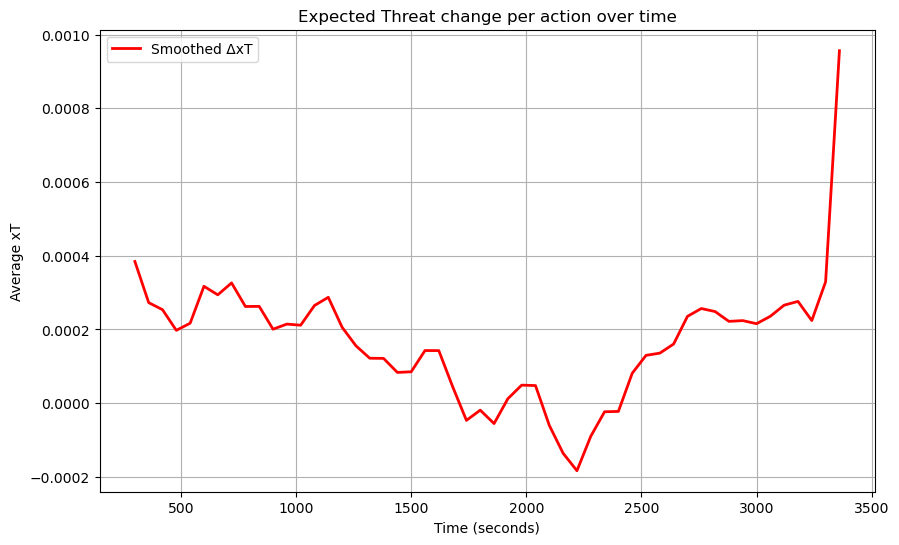

In [34]:
df_filtered = df[df['time'] <= 3600].copy()

interval = 60
df_filtered['time_bin'] = (df_filtered['time'] // interval) * interval

grouped = df_filtered.groupby('time_bin')['delta_xT'].mean().reset_index()

# Rolling average voor smoothing
window_size = 10
grouped['delta_smooth'] = grouped['delta_xT'].rolling(window=window_size, center=True).mean()

# Plot
plt.figure(figsize=(10,6))
plt.plot(grouped['time_bin'], grouped['delta_smooth'], color='red', linewidth=2, label='Smoothed ΔxT')
plt.xlabel("Time (seconds)")
plt.ylabel("Average xT")
plt.title("Expected Threat change per action over time")
plt.legend()
plt.grid(True)
plt.show()